**Load the Dataset**

In [1]:
# Import necessary libraries for data loading
import pandas as pd

# Load the customer data from a CSV file
df = pd.read_csv('/content/drive/MyDrive/Data Sets/customer_behavior_analytcis (2).csv')
# Display initial data shape and check for missing values to understand the dataset
print("Initial Data Shape:", df.shape)
print("Missing Values:\n", df.isnull().sum())

Initial Data Shape: (999, 6)
Missing Values:
 total_purchases     20
avg_cart_value      20
total_time_spent     0
product_click       20
discount_counts      0
customer_id          0
dtype: int64


**Preprocess the Data**

In [2]:
# Handle missing values by imputing with median to preserve distribution
for col in ['total_purchases', 'avg_cart_value', 'total_time_spent', 'product_click', 'discount_counts']:
    df[col].fillna(df[col].median(), inplace=True)

<ipython-input-2-4cbd46e161d3>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


In [3]:
# Define a function to cap outliers using the IQR method for robust preprocessing
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)  # 25th percentile
    Q3 = df[column].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1                   # Interquartile range
    lower_bound = Q1 - 1.5 * IQR    # Lower outlier threshold
    upper_bound = Q3 + 1.5 * IQR    # Upper outlier threshold
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)  # Cap values
    return df

# Apply outlier capping to numeric columns to reduce noise
for col in ['total_purchases', 'avg_cart_value', 'total_time_spent', 'product_click', 'discount_counts']:
    df = cap_outliers(df, col)

In [4]:
# Ensure no negative values remain in numeric columns (business logic constraint)
for col in df.columns:
    if col != 'customer_id':
        df[col] = df[col].clip(lower=0)

In [5]:
# Drop customer_id as it’s an identifier, not a feature for clustering
X = df.drop(columns=['customer_id'])
print("Data Shape After Preprocessing:", X.shape)

Data Shape After Preprocessing: (999, 5)


**Advanced Feature Engineering**

In [6]:
# Create new features to capture nuanced customer behaviors
X['purchases_per_minute'] = X['total_purchases'] / X['total_time_spent'].replace(0, 1)  # Purchase efficiency
X['cart_value_per_click'] = X['avg_cart_value'] / X['product_click'].replace(0, 1)     # Value per product view
X['discount_usage_rate'] = X['discount_counts'] / X['total_purchases'].replace(0, 1)   # Discount reliance
X['browsing_activity'] = X['total_time_spent'] * X['product_click']                    # Browsing intensity

# Replace any NaN or infinite values resulting from division with 0
X.fillna(0, inplace=True)

**Standardize Features**

In [7]:
# Import the scaler for feature standardization
from sklearn.preprocessing import StandardScaler

# Standardize all features to zero mean and unit variance for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Confirm the shape of the standardized data
print("Features Standardized. Shape of X_scaled:", X_scaled.shape)

Features Standardized. Shape of X_scaled: (999, 9)


**Exploratory Data Analysis (EDA)**

Summary Statistics:
        total_purchases  avg_cart_value  total_time_spent  product_click  \
count       999.000000      999.000000        999.000000     999.000000   
mean         11.539540       74.935896         49.348759      28.093093   
std           6.949156       54.635622         32.730973      16.164124   
min           0.000000       10.260000          5.120000       4.000000   
25%           6.000000       33.350000         22.375000      16.000000   
50%          10.000000       49.380000         40.360000      21.000000   
75%          17.000000      118.490000         77.170000      45.000000   
max          32.000000      199.770000        119.820000      73.000000   

       discount_counts  purchases_per_minute  cart_value_per_click  \
count       999.000000            999.000000            999.000000   
mean          4.309309              0.583043              3.660482   
std           4.519267              0.789482              3.400546   
min           0.000000 

<Figure size 1500x1000 with 0 Axes>

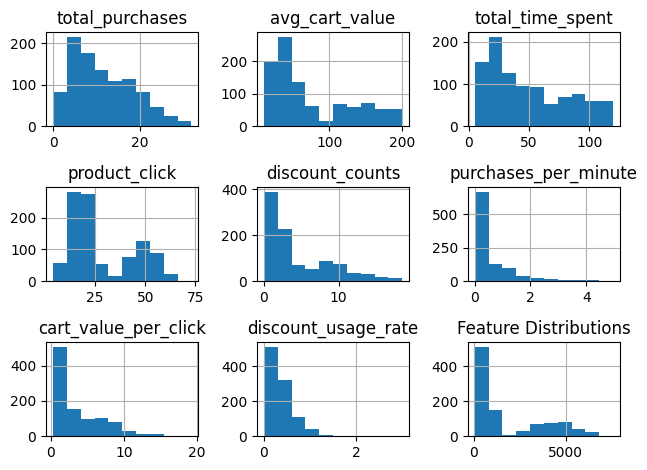

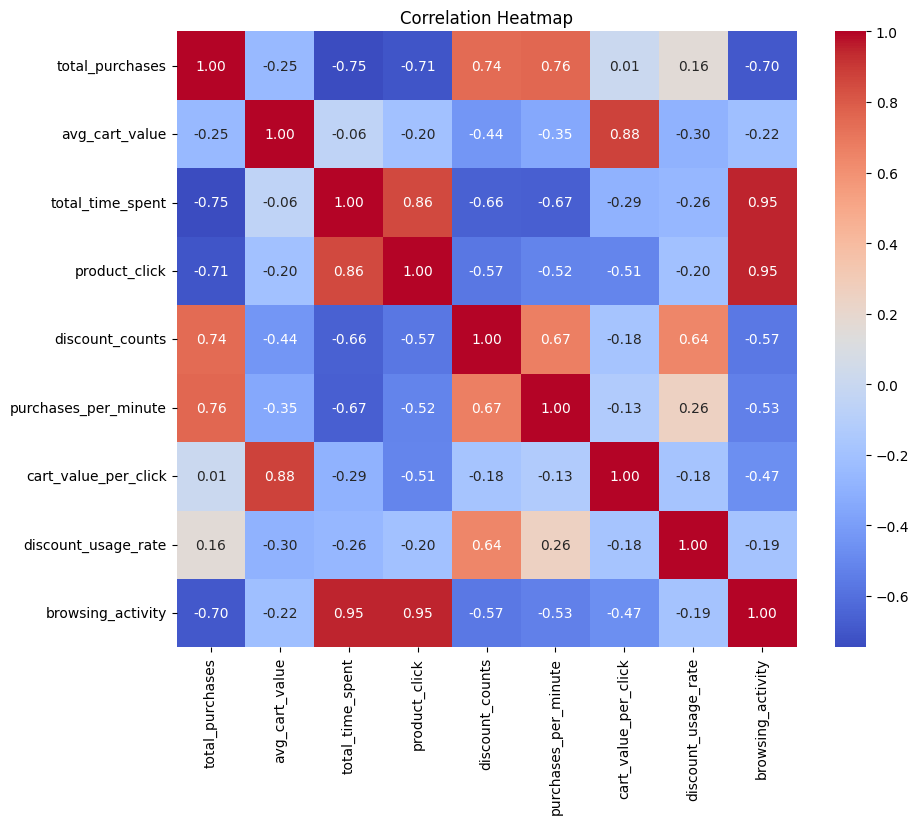

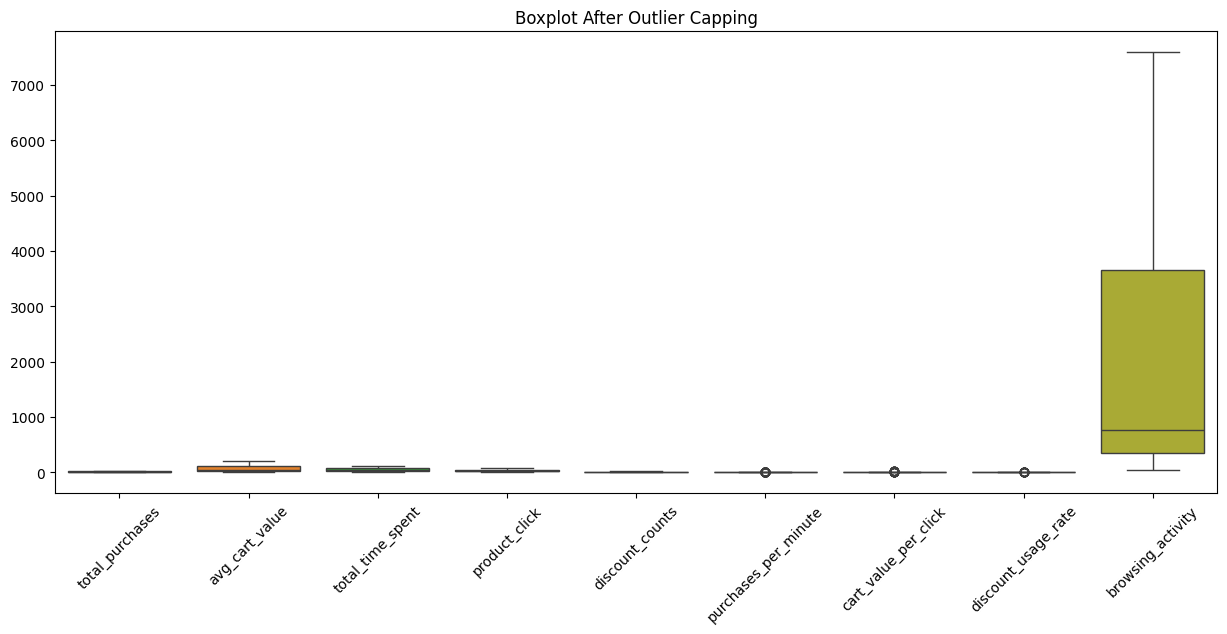

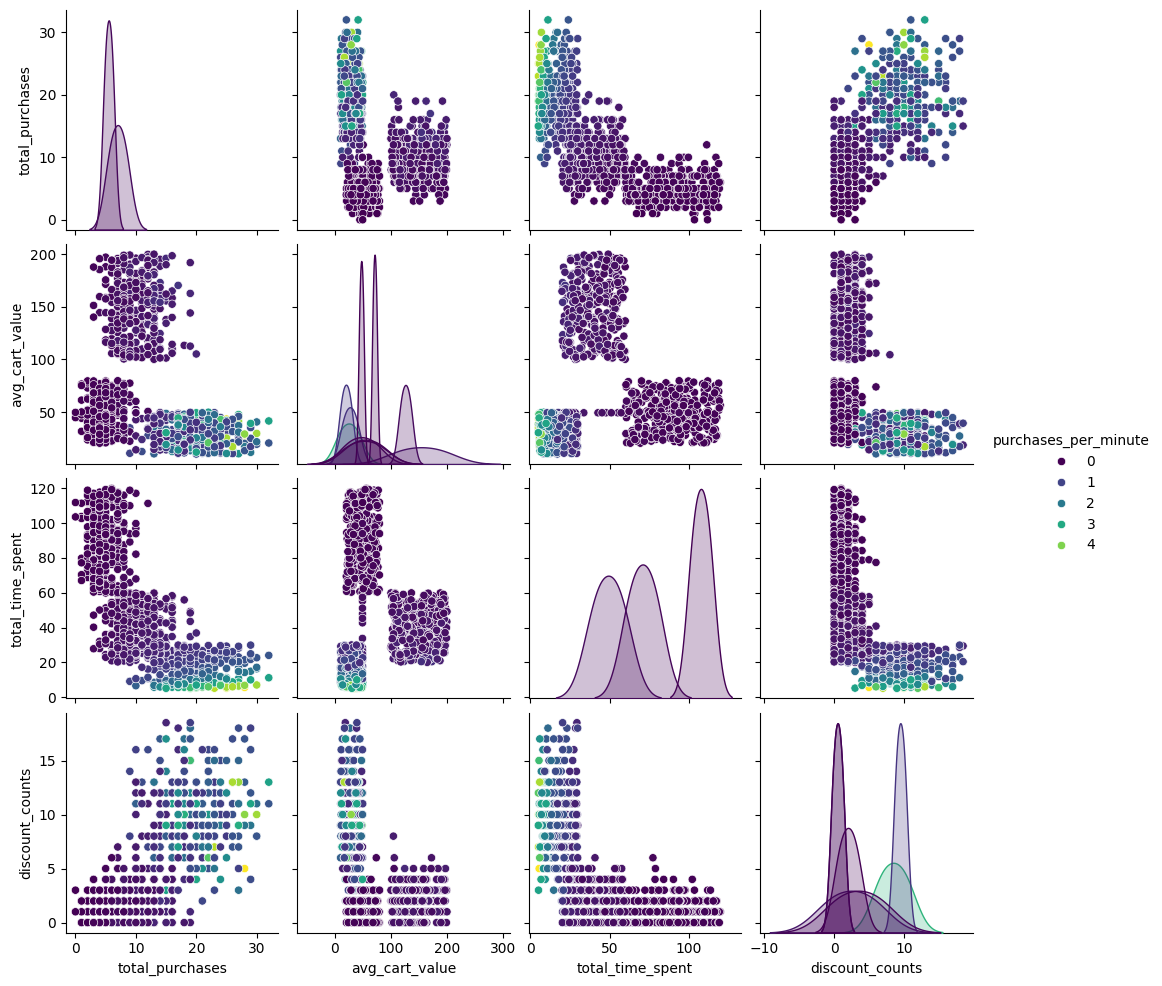

In [9]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Generate summary statistics to understand feature distributions
print("Summary Statistics:\n", X.describe())

# Plot histograms to visualize feature distributions
plt.figure(figsize=(15, 10))
X.hist()
plt.tight_layout()
plt.title("Feature Distributions")
plt.show()

# Create a correlation heatmap to explore feature relationships
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# Boxplots to check post-outlier capping
plt.figure(figsize=(15, 6))
sns.boxplot(data=X)
plt.xticks(rotation=45)
plt.title('Boxplot After Outlier Capping')
plt.show()

# Pairplot (subset for clarity, e.g., original features + 1 new feature)
sns.pairplot(X[['total_purchases', 'avg_cart_value', 'total_time_spent', 'discount_counts', 'purchases_per_minute']], hue='purchases_per_minute', palette='viridis')
plt.show()

**Model Selection and Training**

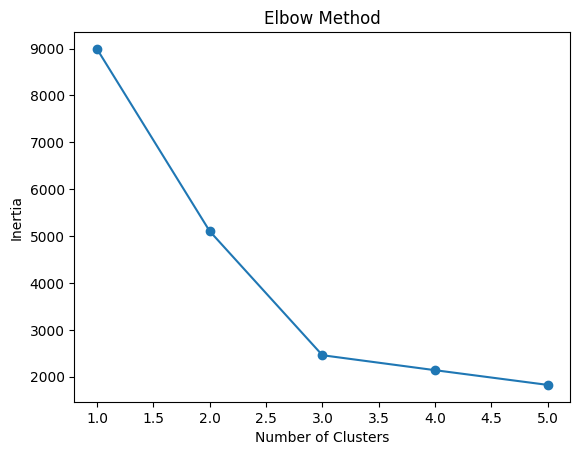

In [10]:
# Import clustering and evaluation libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Use Elbow Method to explore the optimal number of clusters
inertia = []
for k in range(1, 6):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)  # k-means++ for better centroids
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)  # Store inertia (within-cluster sum of squares)

# Plot the Elbow curve
plt.plot(range(1, 6), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

k=2: Silhouette=0.439, DB=0.895, CH=759.068
k=3: Silhouette=0.548, DB=0.686, CH=1323.201
k=4: Silhouette=0.522, DB=0.798, CH=1062.297
k=5: Silhouette=0.462, DB=0.975, CH=975.610


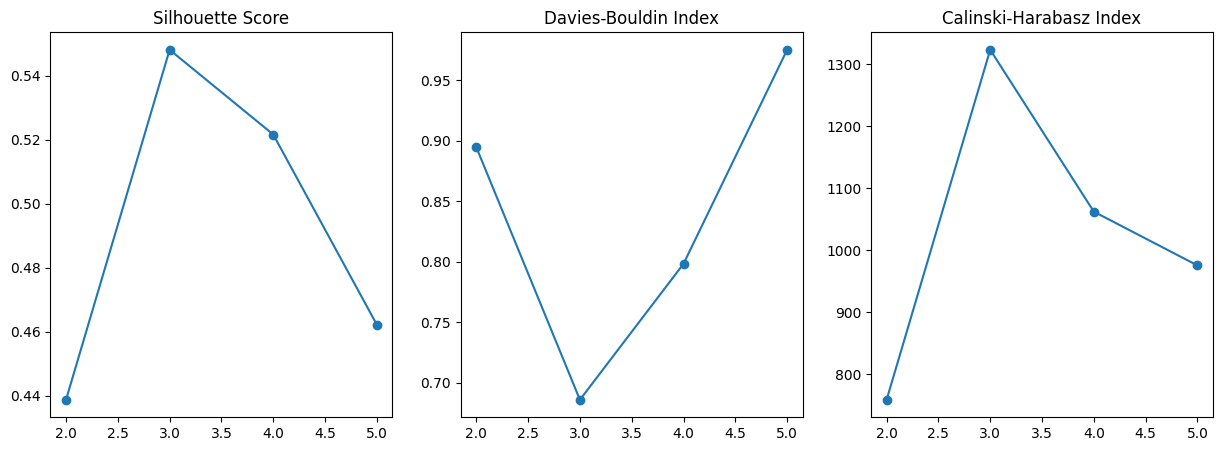

In [12]:
# Evaluate clustering metrics to confirm k=3
silhouette_scores = []
db_scores = []
ch_scores = []
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(X_scaled, labels))          # Cohesion vs. separation
    db_scores.append(davies_bouldin_score(X_scaled, labels))              # Cluster similarity
    ch_scores.append(calinski_harabasz_score(X_scaled, labels))           # Between vs. within variance
    print(f'k={k}: Silhouette={silhouette_scores[-1]:.3f}, DB={db_scores[-1]:.3f}, CH={ch_scores[-1]:.3f}')

# Plot metrics for comparison
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.plot(range(2, 6), silhouette_scores, marker='o')
ax1.set_title('Silhouette Score')
ax2.plot(range(2, 6), db_scores, marker='o')
ax2.set_title('Davies-Bouldin Index')
ax3.plot(range(2, 6), ch_scores, marker='o')
ax3.set_title('Calinski-Harabasz Index')
plt.show()

In [13]:
# Train optimized K-Means with k=3
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, random_state=42, max_iter=300)
kmeans.fit(X_scaled)
X['kmeans_cluster'] = kmeans.labels_

In [14]:
# Train GMM as an alternative model
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42, max_iter=100)
gmm.fit(X_scaled)
X['gmm_cluster'] = gmm.predict(X_scaled)

**Model Evaluation**

In [15]:
# Import numpy for stability analysis
import numpy as np

# Evaluate K-Means with multiple metrics
kmeans_silhouette = silhouette_score(X_scaled, X['kmeans_cluster'])
kmeans_db = davies_bouldin_score(X_scaled, X['kmeans_cluster'])
kmeans_ch = calinski_harabasz_score(X_scaled, X['kmeans_cluster'])
print(f"K-Means: Silhouette={kmeans_silhouette:.3f}, DB={kmeans_db:.3f}, CH={kmeans_ch:.3f}")

# Evaluate GMM with multiple metrics
gmm_silhouette = silhouette_score(X_scaled, X['gmm_cluster'])
gmm_db = davies_bouldin_score(X_scaled, X['gmm_cluster'])
gmm_ch = calinski_harabasz_score(X_scaled, X['gmm_cluster'])
print(f"GMM: Silhouette={gmm_silhouette:.3f}, DB={gmm_db:.3f}, CH={gmm_ch:.3f}")

K-Means: Silhouette=0.548, DB=0.686, CH=1323.201
GMM: Silhouette=0.546, DB=0.692, CH=1312.992


In [16]:
#Assess K-Means stability using bootstrapping
n_bootstraps = 10
stability_scores = []
for _ in range(n_bootstraps):
    sample_idx = np.random.choice(X_scaled.shape[0], size=int(0.8 * X_scaled.shape[0]), replace=True)
    X_sample = X_scaled[sample_idx]
    kmeans_sample = KMeans(n_clusters=3, init='k-means++', n_init=10, random_state=42)
    kmeans_sample.fit(X_sample)
    stability_scores.append(silhouette_score(X_sample, kmeans_sample.labels_))
print(f"K-Means Stability (Mean Silhouette): {np.mean(stability_scores):.3f} ± {np.std(stability_scores):.3f}")


K-Means Stability (Mean Silhouette): 0.547 ± 0.008


In [17]:
# Statistical profiling with ANOVA to validate cluster differences
from scipy.stats import f_oneway
for col in X.columns[:-2]:  # Exclude cluster columns
    groups = [X[col][X['kmeans_cluster'] == i] for i in range(3)]
    f_stat, p_val = f_oneway(*groups)
    print(f"ANOVA for {col}: F={f_stat:.2f}, p={p_val:.4f}")

ANOVA for total_purchases: F=1518.93, p=0.0000
ANOVA for avg_cart_value: F=2576.16, p=0.0000
ANOVA for total_time_spent: F=3029.15, p=0.0000
ANOVA for product_click: F=3597.28, p=0.0000
ANOVA for discount_counts: F=1859.08, p=0.0000
ANOVA for purchases_per_minute: F=673.48, p=0.0000
ANOVA for cart_value_per_click: F=1401.70, p=0.0000
ANOVA for discount_usage_rate: F=139.75, p=0.0000
ANOVA for browsing_activity: F=4032.89, p=0.0000


**Cluster Identification and Visualization**

In [18]:
# Summarize cluster characteristics for K-Means
cluster_summary = X.groupby('kmeans_cluster').mean()
print("K-Means Cluster Summary:\n", cluster_summary)

# Assign meaningful labels based on cluster characteristics
cluster_names = {
    0: 'Bargain Hunters',  # Expected: High total_purchases, high discount_usage_rate, low avg_cart_value
    1: 'High Spenders',    # Expected: High avg_cart_value, moderate total_purchases, low discount_usage_rate
    2: 'Window Shoppers'  # Expected: Low purchases_per_minute, high browsing_activity
}
X['cluster_name'] = X['kmeans_cluster'].map(cluster_names)

K-Means Cluster Summary:
                 total_purchases  avg_cart_value  total_time_spent  \
kmeans_cluster                                                      
0                     10.170659      144.687874         40.472126   
1                      4.924699       49.034066         90.211837   
2                     19.507508       30.798498         17.511682   

                product_click  discount_counts  purchases_per_minute  \
kmeans_cluster                                                         
0                   19.925150         1.940120              0.271960   
1                   49.370482         1.027108              0.056544   
2                   15.072072         9.957958              1.419977   

                cart_value_per_click  discount_usage_rate  browsing_activity  \
kmeans_cluster                                                                 
0                           7.721851             0.209600         804.677575   
1                          

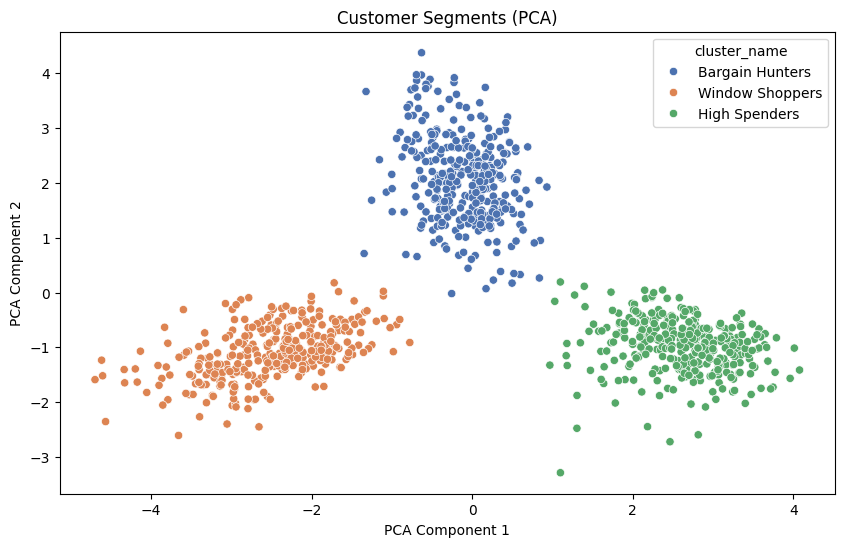

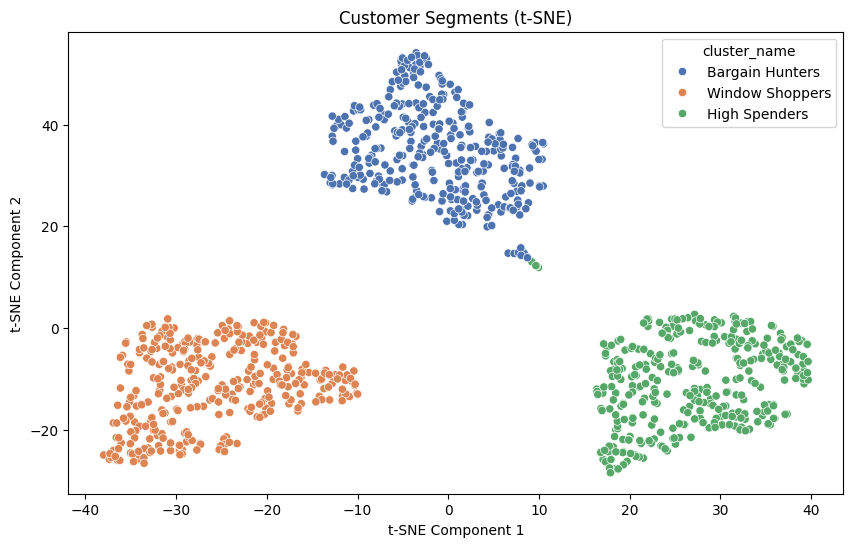

In [19]:
# Visualize clusters using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=X['cluster_name'], palette='deep')
plt.title('Customer Segments (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Visualize clusters using t-SNE for a non-linear view
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=X['cluster_name'], palette='deep')
plt.title('Customer Segments (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [20]:
# Save the final DataFrame with cluster assignments to a CSV file
X.to_csv('customer_segments_output.csv', index=False)
print("Results saved to 'customer_segments_output.csv'")

Results saved to 'customer_segments_output.csv'
